In [203]:
from typing import Callable

import pickle
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence
import torch.nn.functional as F

from sklearn.model_selection import ParameterGrid, ParameterSampler

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
from math import ceil

import json

from Metrics import Metrics
from rnn_utils import split_dataset

### Checking for GPU availability
#This model was trained on a GPU enabled system...highly recommended.

# check if GPU is available
if(torch.cuda.is_available()):
    print('Training on GPU!')
else: 
    print('Training on CPU!')

Training on GPU!


In [195]:
# Reproducibility
np.random.seed(546)
torch.manual_seed(546)
torch.cuda.manual_seed(546)

In [196]:
class DiagnosesDataset(Dataset):
    def __init__(self, diagnoses_file,
                 grouping='ccs' # desired grouping to use (for both input and output currently),
                ):
        
        # load admissions data
        with open(diagnoses_file,'r') as fp:
            self.data = json.load(fp)
        
        # list patients
        self.patients = list(self.data['data'].keys())
        
        self.grouping = grouping
        
        # necessary data of each code_grouping (eg. ccs, chapters) for posterior padding and one_hot_encoding of batches
        self.grouping_data = {}
        for grouping_code in self.data['metadata']['groupings']:
            self.grouping_data[grouping_code] = {}
            
            # get all codes of this group
            all_data_grouping = [self.data['data'][pat][grouping_code] for pat in self.data['data']]
            
            #flatten list of lists of lists
            all_data_grouping = [item for sublist in all_data_grouping for item in sublist]
            all_data_grouping = [item for sublist in all_data_grouping for item in sublist]
            
            # store n_labels this group
            self.grouping_data[grouping_code]['n_labels'] = len(set(all_data_grouping))
            
            # store unique sorted codes from dataset
            self.grouping_data[grouping_code]['sorted'] = sorted(set(all_data_grouping))
            
            # store code2int & int2code
            int2code = dict(enumerate(self.grouping_data[grouping_code]['sorted']))
            code2int = {ch: ii for ii, ch in int2code.items()}
            
            self.grouping_data[grouping_code]['int2code'] = int2code
            self.grouping_data[grouping_code]['code2int'] = code2int
            self.grouping_data[grouping_code]['int2code_converter'] = lambda idx: self.grouping_data[grouping_code]['int2code'][idx]
        
    def __str__(self):
        return 'Available groupings: ' +str(self.data['metadata']['groupings'])

    def __len__(self):
        return len(self.data['data'])

    def __getitem__(self, idx):
        """
        gets original converted from int2code
        """
        patient_data = self.data['data'][self.patients[idx]][self.grouping]
        
        train = patient_data[:-1]
        target = patient_data[1:]
        
        # remove duplicates (can happen in low granuality codes such as ccs)
        
        train = [list(set(admission)) for admission in train]
        target = [list(set(admission)) for admission in target]
        
        return {'train':train,'target':target}

In [197]:
class MYCOLLATE:
    """
    This collate class gets a dataset in the format of:
    [
    {'train':[[code1,code2],[code3,code4,code5],etc..]
      'target:':[[code1,code2],[code3,code4,code5],etc..]
    },
     {etc..},
     etc..
    ]
    
    And outputs a pack of train and test sequences
    """
    def __init__(self,dataset):
        self.dataset = dataset
    
    def __call__(self,batch):
        patients = {'train':{'sequence':[],'original':[]},
                    'target':{'sequence':[],'original':[]}}
        
        grouping_code = self.dataset.grouping
        n_labels = self.dataset.grouping_data[grouping_code]['n_labels']
        code2int = self.dataset.grouping_data[grouping_code]['code2int']
        
        # <Nº admissions - 1> of each patient
        seq_lengths = []
        for pat in batch:
            train_admissions_sequenced = []
            target_admissions_sequenced = []
            seq_lengths.append(len(pat))

            # convert each train admission into a multi-hot vector
            for train_admission in pat['train']:
                admission = (F.one_hot(torch.tensor(list(map(lambda code: code2int[code],train_admission))),num_classes=n_labels)
                             .sum(dim=0).float() #one-hot of each diagnose to multi-hot vector of diagnoses
                            )
                train_admissions_sequenced.append(admission)

            # convert each target admission into a one-hot vector
            for target_admission in pat['target']:
                # convert each admission to multi-hot vector
                admission = (F.one_hot(torch.tensor(list(map(lambda code: code2int[code],target_admission))),num_classes=n_labels)
                             .sum(dim=0).float() #one-hot of each diagnose to multi-hot vector of diagnoses
                            )
                target_admissions_sequenced.append(admission)

            # stack multiple train admissions of a single patient into a single tensor
            if len(train_admissions_sequenced) > 1:
                train_admissions_sequenced = torch.stack(train_admissions_sequenced)
            else:
                train_admissions_sequenced = train_admissions_sequenced[0].view((1,-1))

            # stack multiple target admissions of a single patient into a single tensor
            if len(target_admissions_sequenced) > 1:
                target_admissions_sequenced = torch.stack(target_admissions_sequenced)
            else:
                target_admissions_sequenced = target_admissions_sequenced[0].view((1,-1))

            # store final train and test tensors
            patients['train']['sequence'].append(train_admissions_sequenced)
            patients['target']['sequence'].append(target_admissions_sequenced)
            
            patients['train']['original'].append(pat['train'])
            patients['target']['original'].append(pat['target'])

        # pad sequences (some patients have more admissions than others)
        patients['train']['sequence'] = pack_sequence(patients['train']['sequence'],enforce_sorted=False)
        patients['target']['sequence'] = pad_sequence(patients['target']['sequence'],batch_first=True)
        
        # pack the padded sequences
        
        #patients['train'] = pack_padded_sequence(patients['train'],lengths=seq_lengths,batch_first=True)
        #patients['target'] = pack_padded_sequence(patients['target'],lengths=seq_lengths,batch_first=True)
        return {'train_sequences':patients['train'],'target_sequences':patients['target']}

In [198]:
class RNN(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_layers,n_labels,model='rnn'):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.n_labels = n_labels
        
        if model == 'rnn':
            self.model = nn.RNN(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers
                             )
        elif model == 'gru':
            self.model = nn.GRU(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers
                             )
        elif model == 'lstm':
            self.model = nn.LSTM(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers
                             )
        else:
            raise ValueError(f'oops. expecting model in [rnn,lstm,gru], got model={model}')
        
        self.lin = nn.Linear(in_features = hidden_size,
                            out_features=n_labels
                           )
    
    def forward(self, input):
        """
        input: pack_sequence
        
        """
        
        hn,_ = self.model(input)
        
        out = self.lin(pad_packed_sequence(hn,batch_first=True)[0])
        return out

# Let's try to run the net

## prepare train and test splits

**3 batches**:
- train_dataloader
- val_dataloader
- test_dataloader

In [199]:
batch_size = 64
grouping = 'ccs'

In [204]:
dataset = DiagnosesDataset('data/model_data.json',grouping)
test_size = 0.15
eval_size=0.15
eval_size_corrected = eval_size/(1-test_size)

whole_train_dataset_temp,test_dataset = split_dataset(dataset,test_size)
whole_train_dataset
train_dataset, val_dataset = split_dataset(whole_train_dataset.dataset,eval_size_corrected)

len(train_dataset)
len(val_dataset)
len(test_dataset)

whole_train_dataset = DataLoader(whole_train_dataset.dataset,batch_size=batch_size,collate_fn=MYCOLLATE(whole_train_dataset.dataset),shuffle=True)
train_dataloader = DataLoader(train_dataset.dataset,batch_size=batch_size,collate_fn=MYCOLLATE(train_dataset.dataset),shuffle=True)
val_dataloader = DataLoader(val_dataset.dataset,batch_size=batch_size,collate_fn=MYCOLLATE(val_dataset.dataset)) #batch_size here is arbitrary and doesn't affect total validation speed
test_dataloader = DataLoader(test_dataset.dataset,batch_size=batch_size,collate_fn=MYCOLLATE(test_dataset.dataset))

6176

1323

1124

In [205]:
hidden_size=75
num_layers=1
input_size = n_labels = next(iter(train_dataloader))['target_sequences']['sequence'].shape[2]

# Converting outs from the model to predictions

In [183]:
def outs2pred(outs, int2code : dict):
    """Converts the outputs of a model (logits) to diagnostic code predictions.
    
    Parameters
    ---------
    
    out: outputs of a model on a batch of variable-sized sequences
    
    int2code: dict mapping idx to diagnostic code
    
    """
    activations = nn.Sigmoid()(outs).detach().numpy()
    
    sorted_idx = np.argsort(activations)
    
    return np.vectorize(int2code.get)(sorted_idx)[:,:,::-1]

## Example

In [136]:
model = RNN(input_size=input_size,
              hidden_size=100,
              num_layers=num_layers,
              n_labels=n_labels,
              model='gru')
model.eval()

batch = next(iter(train_dataloader))
# get the inputs; data is a list of [inputs, labels]
history_sequences, target_sequences = batch['train_sequences'],batch['target_sequences']

outs = model(history_sequences['sequence'])
_,lengths = pad_packed_sequence(history_sequences['sequence'])
lengths = lengths.detach().numpy()

int2code_dict = train_dataloader.dataset.grouping_data[grouping]['int2code']
convert_batch_out_2_predictions_faster(outs,lengths,int2code_dict)

RNN(
  (model): GRU(272, 100)
  (lin): Linear(in_features=100, out_features=272, bias=True)
)

array([[[ 251, 2607,   25, ...,    8,   39,  241],
        [ 234,   81,   95, ...,    8,   32,  114],
        [ 234,   81,   95, ...,    8,   32,  114],
        ...,
        [ 234,   81,   95, ...,    8,   32,  114],
        [ 234,   81,   95, ...,    8,   32,  114],
        [ 234,   81,   95, ...,    8,   32,  114]],

       [[ 180,  201,   33, ...,  159,   32,   38],
        [ 234,   81,   95, ...,    8,   32,  114],
        [ 234,   81,   95, ...,    8,   32,  114],
        ...,
        [ 234,   81,   95, ...,    8,   32,  114],
        [ 234,   81,   95, ...,    8,   32,  114],
        [ 234,   81,   95, ...,    8,   32,  114]],

       [[ 115,   92,  251, ...,   18,    8,   60],
        [ 180,  251,  650, ...,   38,   98,    8],
        [ 180,   57,  650, ...,   32,   98,    8],
        ...,
        [ 234,   81,   95, ...,    8,   32,  114],
        [ 234,   81,   95, ...,    8,   32,  114],
        [ 234,   81,   95, ...,    8,   32,  114]],

       ...,

       [[ 195,    6,   1

# Compute metrics from predictions & targets

In [158]:
def compute_metrics(preds, targets):
    """ 
    Computes recall for a batch of predictions. 
    Returns the average of each metric at the end in the format {metric:avg,metric2:avg,etc..}
    """
    
    levels = ['1 adm','2 adm','3 adm','>3 adm','last adm']
    recall_at = [10,20,30]
    
    res = dict()
    for key in levels:
        res[key] = {f'recall{k}':[] for k in recall_at}
    
    for idx_pat, pat in enumerate(targets):
        for idx_adm,adm in enumerate(pat):
            for k in recall_at:
                if idx_adm +1 <=3:
                    res[f'{idx_adm+1} adm'][f'recall{k}'].append(Metrics.recall(adm,preds[idx_pat][idx_adm],k=k))
                else:
                    res[f'>3 adm'][f'recall{k}'].append(Metrics.recall(adm,preds[idx_pat][idx_adm],k=k))
                
                # we are at the last admission.
                if idx_adm+1 == len(pat):
                    res['last adm'][f'recall{k}'].append(Metrics.recall(adm,preds[idx_pat][idx_adm],k=k))
    return res


def concat_metrics(old_metrics:dict,new_metrics:dict):
    # dicts are passed by reference
    # so i just update whatever was passed to <old_metrics>
    for level in old_metrics:
        for metric in old_metrics[level]:
            old_metrics[level][metric].extend(new_metrics[level][metric])
    return None

## Example

In [157]:
model = RNN(input_size=input_size,
              hidden_size=100,
              num_layers=num_layers,
              n_labels=n_labels,
              model='gru')
model.eval()

batch = next(iter(train_dataloader))
# get the inputs; data is a list of [inputs, labels]
history_sequences, target_sequences = batch['train_sequences'],batch['target_sequences']

outs = model(history_sequences['sequence'])
_,lengths = pad_packed_sequence(history_sequences['sequence'])
lengths = lengths.detach().numpy()

int2code_dict = train_dataloader.dataset.grouping_data[grouping]['int2code']
preds = outs2pred(outs,int2code_dict)


res = compute_metricsV2(preds,target_sequences['original'])

# show some stuff
print(res['last adm']['recall10'])

RNN(
  (model): GRU(272, 100)
  (lin): Linear(in_features=100, out_features=272, bias=True)
)

[0.0, 0.047619047619047616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.11764705882352941, 0.0, 0.0, 0.0, 0.125, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.1, 0.07407407407407407, 0.0, 0.1111111111111111, 0.0, 0.05263157894736842, 0.0, 0.07142857142857142, 0.058823529411764705, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.058823529411764705, 0.0, 0.0, 0.0625, 0.07142857142857142, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111]


# Eval model

In [177]:
def eval_model(model, dataloader, criterion, epoch, name, only_loss=False):
    """
    This functions evaluates and computes metrics of a model checkpoint on a dataloader
    """
    
    # eg:: ccs, icd9, etc..
    code_type = dataloader.dataset.grouping
    
    
    int2code = dataloader.dataset.grouping_data[code_type]['int2code']
    
    result = {'name':name,
              'epoch':epoch
             }
    
    total_loss = 0
    total_seq = 0 #total sequences
    
    all_metrics = None
    with torch.no_grad():
        for i, batch in enumerate(iter(dataloader)):
            
            # get the inputs; data is a list of [inputs, labels]
            history_sequences, target_sequences = batch['train_sequences'],batch['target_sequences']

            outs = model(history_sequences['sequence'])

            loss = criterion(outs, target_sequences['sequence'])

            # compute loss
            n = target_sequences['sequence'].size(0)
            total_seq += n
            total_loss += loss.item() * n
            
            # compute other metrics

            _,lengths = pad_packed_sequence(history_sequences['sequence'])
            
            preds = outs2pred(outs,int2code)
            
            if all_metrics is None:
                all_metrics = compute_metrics(preds,target_sequences['original'])
            else:
                new_metrics = compute_metrics(preds,target_sequences['original'])
                concat_metrics(all_metrics,new_metrics)

        result['loss'] = total_loss / total_seq
        if only_loss:
            return result
        for level in all_metrics:
            if level not in result:
                result[level] = {}
            for metric in all_metrics[level]:
                if metric not in result[level].keys():
                    result[level][metric] = {}
                result[level][metric] = {'mean':np.mean(all_metrics[level][metric]),
                                         'std':np.std(all_metrics[level][metric]),
                                         'n': len(all_metrics[level][metric])
                                        }
    return result

## Example

In [172]:
## Example eval_model

model = RNN(input_size=input_size,
              hidden_size=100,
              num_layers=num_layers,
              n_labels=n_labels,
              model='gru')

opt = torch.optim.Adam(model.parameters(), lr=0.02)
criterion = nn.BCEWithLogitsLoss()

res = eval_model(model, val_dataloader, criterion, epoch,'val')

done here


In [173]:
res

{'name': 'val',
 'epoch': 3,
 'loss': 0.6932924579009802,
 '1 adm': {'recall10': {'mean': 0.022220470884709208,
   'std': 0.04869707662564347,
   'n': 7499},
  'recall20': {'mean': 0.04922809333090191,
   'std': 0.07253438597216255,
   'n': 7499},
  'recall30': {'mean': 0.07987495790207726,
   'std': 0.0981748012054294,
   'n': 7499}},
 '2 adm': {'recall10': {'mean': 0.025817457278895485,
   'std': 0.057913734902979894,
   'n': 2374},
  'recall20': {'mean': 0.0553148705746406,
   'std': 0.07775293177598733,
   'n': 2374},
  'recall30': {'mean': 0.0869839970474674,
   'std': 0.08965554567738389,
   'n': 2374}},
 '3 adm': {'recall10': {'mean': 0.02741393369361806,
   'std': 0.04801716203732152,
   'n': 1033},
  'recall20': {'mean': 0.05792350042884539,
   'std': 0.06568919505834019,
   'n': 1033},
  'recall30': {'mean': 0.09308716741743037,
   'std': 0.08313247879423646,
   'n': 1033}},
 '>3 adm': {'recall10': {'mean': 0.03231670332815459,
   'std': 0.05135653832659585,
   'n': 1506},
  

# Train one epoch

In [174]:
def train_one_epoch(model, train_loader, epoch, criterion, optimizer):
    """
    Trains one epoch and returns mean loss over training
    """
    model.train()
    
    total_loss = 0
    total_n = 0
    for i, batch in enumerate(iter(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        history_sequences, target_sequences = batch['train_sequences'],batch['target_sequences']

        # zero the parameter gradients
        model.zero_grad()

        # forward + backward + optimize
        
        outs = model(history_sequences['sequence'])
        
        loss = criterion(outs, target_sequences['sequence'])
        loss.backward()
        
        opt.step()
        
        _,lengths = pad_packed_sequence(history_sequences['sequence'])
        
        n = lengths.sum().item()
        
        total_loss += loss.item() * n
        total_n += n
    return total_loss / total_n

## Example

CPU times: user 1min 18s, sys: 37 ms, total: 1min 18s
Wall time: 1min 18s


<AxesSubplot:>

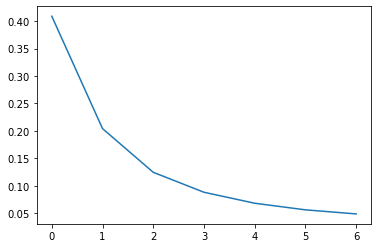

In [184]:
%%time
## Example eval_model

model = RNN(input_size=input_size,
              hidden_size=100,
              num_layers=num_layers,
              n_labels=n_labels,
              model='gru')

opt = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

losses = []
val_metrics = []
for epoch in range(0,7):
    loss = train_one_epoch(model,train_dataloader, 1, criterion, opt)
    losses.append(loss)
    if epoch % 2 == 0:
        val_metrics.append(eval_model(model,val_dataloader,criterion,epoch,'val'))
pd.Series(losses).plot()

In [186]:
val_metrics[0]['loss']
val_metrics[-1]['loss']

0.2689212545074929

0.045974987054176374

In [187]:
val_metrics[0]['1 adm']

{'recall10': {'mean': 0.3701218691926719,
  'std': 0.18219751326524034,
  'n': 7499},
 'recall20': {'mean': 0.5295617367666753,
  'std': 0.18774851693388908,
  'n': 7499},
 'recall30': {'mean': 0.640873301892558,
  'std': 0.17920721807228104,
  'n': 7499}}

In [191]:
val_metrics[0]['last adm']
val_metrics[-1]['last adm']

{'recall10': {'mean': 0.36163155089136967,
  'std': 0.1766170570851731,
  'n': 7499},
 'recall20': {'mean': 0.5236286991838952,
  'std': 0.18212773054602718,
  'n': 7499},
 'recall30': {'mean': 0.635913820216052,
  'std': 0.17583566818017943,
  'n': 7499}}

{'recall10': {'mean': 0.48630403387046084,
  'std': 0.1925538402742622,
  'n': 7499},
 'recall20': {'mean': 0.6620859655520701,
  'std': 0.1773473182249729,
  'n': 7499},
 'recall30': {'mean': 0.7636116507806993,
  'std': 0.15810650249322447,
  'n': 7499}}

# Gridsearch

In [ ]:
rnn = RNN(input_size=input_size,
          hidden_size=hidden_size,
          num_layers=num_layers,
          n_labels=n_labels)

lr = 0.01

opt = torch.optim.Adam(rnn.parameters(), lr=lr)

# contains softmax internally
criterion = nn.BCEWithLogitsLoss()

show_every=100
loss_history = []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, batch in enumerate(iter(train_dataloader)):
        # get the inputs; data is a list of [inputs, labels]
        train_sequence, target_sequence = batch['train_sequences'],batch['target_sequences']

        # zero the parameter gradients
        rnn.zero_grad()

        # forward + backward + optimize
        
        outs = rnn(train_sequence['sequence'])
        
        loss = criterion(outs, target_sequence['sequence'])
        loss.backward()
        
        opt.step()
        
        running_loss += loss.item() * target_sequence.size(0)
        
    loss_history.append(running_loss / len(train_dataloader))
    print('epoch',epoch+1,'Done with loss',loss_history[-1])
    